In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.interpolate
import netCDF4 as nc
import xarray as xr
import scipy.ndimage
import scipy as sp
import alphashape
import glob
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon
from matplotlib import style
import seaborn as sns
pd.options.mode.chained_assignment = None
style.use('default') or plt.style.use('default')
#colors = sns.color_palette('crest', n_colors=6).as_hex()
colors = sns.color_palette('viridis_r', n_colors=6).as_hex()
colors

['#a0da39', '#4ac16d', '#1fa187', '#277f8e', '#365c8d', '#46327e']

### Units used are as in Elmer/Ice:

MPa, a, m
 

In [18]:
# Conversion to Elmer/Ice units

yearinsec = 365.25*24*60*60
rhoi = 900.0/(1.0e6*yearinsec**2)
rhow = 1000.0/(1.0e6*yearinsec**2)
g = -9.8*yearinsec**2


In [19]:
# Lists of fluxes, sigma values (in bed elevation equation) and simulation names

#fluxes = [100, 200, 300, 400, 500]
#sigmas = [4000, 8000, 12000, 16000]
#sims = ['Flux200Sigma2000', 'Flux200Sigma3000', 'Flux250Sigma3000', 'Flux300Sigma4000']
sims = ['Flux50Sigma1000',  'Flux50Sigma2000', \
        'Flux100Sigma1000', 'Flux100Sigma2000', 'Flux100Sigma3000', 'Flux100Sigma4000', \
        'Flux150Sigma2000', 'Flux150Sigma3000', 'Flux150Sigma4000', \
        'Flux200Sigma1000', 'Flux200Sigma2000', 'Flux200Sigma3000', 'Flux200Sigma4000', 'Flux200Sigma5000',\
        'Flux250Sigma1000', 'Flux250Sigma2000', 'Flux250Sigma3000', 'Flux250Sigma4000', 'Flux250Sigma5000', \
        'Flux300Sigma2000', 'Flux300Sigma4000', 'Flux300Sigma5000',\
        'Flux100NoPinningPoint', 'Flux200NoPinningPoint', 'Flux250NoPinningPoint', 'Flux300NoPinningPoint', \
        'Flux200Sigma2000_cyl', 'Flux200Sigma3000_cyl', 'Flux250Sigma3000_cyl', 'Flux300Sigma4000_cyl']


#for i in fluxes:
#    for j in sigmas:
#        sims.append('Flux' + str(i) + 'Sigma' + str(j))

dfs = {}
for sim in sims:
    dfs[sim] = pd.read_csv('../Data/StressWiderDomain/' + str(sim) + '.csv')
    

In [20]:
# Centre domain in the cylinder simualtions

for sim in sims:
    if sim.endswith('cyl'):
        dfs[sim]['Points:0'] = dfs[sim]['Points:0'] - 150000
        

In [21]:
# Calculate the deviatoric stresses

for sim in sims:
    for i in range(1, 4):
        dfs[sim]['dev stress ' + str(i)] = dfs[sim]['stress ' + str(i)] + dfs[sim]['pressure']
        

In [22]:
# Re-order data by the y-coordinate and the z-coordinate

for sim in sims:
    if sim.endswith('cyl'):
        dfs[sim] = dfs[sim].sort_values(by=['Points:0', 'Points:2'])
        dfs[sim] = dfs[sim].reset_index(drop=True)
    else:
        dfs[sim] = dfs[sim].sort_values(by=['Points:1', 'Points:2'])
        dfs[sim] = dfs[sim].reset_index(drop=True)
    

In [23]:
# Calculate the hydrostatic pressure at a point if the ice shelf ended at that point

for sim in sims:
    dfs[sim]['hyd. pressure'] = [0] * len(dfs[sim])

for sim in sims:
    for i in range(len(dfs[sim])):
        if dfs[sim]['Points:2'][i] < 0.0:
            dfs[sim]['hyd. pressure'][i] = - rhow * g * dfs[sim]['Points:2'][i]
        else:
            dfs[sim]['hyd. pressure'][i] = 0.0
    
# Subtract the hydrostatic pressure from stess

for sim in sims:
    if sim.endswith('cyl'):
        dfs[sim]['stress 2 - hyd. p.'] = dfs[sim]['stress 2'] - dfs[sim]['hyd. pressure']
        dfs[sim]['dev stress 2 - hyd. p.'] = dfs[sim]['stress 2'] - dfs[sim]['hyd. pressure'] + dfs[sim]['pressure']
    else:
        dfs[sim]['stress 1 - hyd. p.'] = dfs[sim]['stress 1'] - dfs[sim]['hyd. pressure']
        dfs[sim]['dev stress 1 - hyd. p.'] = dfs[sim]['stress 1'] - dfs[sim]['hyd. pressure'] + dfs[sim]['pressure']

In [24]:
# Function to vertically integrate data
# As input, it takes a dataframe, number of vertical nodes, variable and coordinate of interest

def VertInt(df, N, var, coord, TN = False):
    if TN == True:
        min_z = dict.fromkeys(df[coord], 0)
        max_z = dict.fromkeys(df[coord], 0)
        thickness = dict.fromkeys(df[coord], 0)
        for i in range(len(df[coord])):
            if df["Points:2"][i] < min_z[df[coord][i]]:
                min_z[df[coord][i]] = df["Points:2"][i]
            if df["Points:2"][i] > max_z[df[coord][i]]:
                max_z[df[coord][i]] = df["Points:2"][i]
        for key in thickness.keys():
            thickness[key] = max_z[key] - min_z[key]
    field = dict.fromkeys(df[coord], 0)
    Coord = dict.fromkeys(df[coord], 0)
    for i in df[coord]:
        Coord[i] += 1
    incorrect_coord_values = [k for k, v in Coord.items() if v != N]
    correct_coord_values = [k for k, v in Coord.items() if v == N]
    for i in incorrect_coord_values:
        Coord = {i:Coord[i] for i in Coord if i not in incorrect_coord_values}
        field = {i:field[i] for i in field if i not in incorrect_coord_values}
    df = df[~df[coord].isin(incorrect_coord_values)]
    df_height0 = df[df['height'] < 0.1]
    df_depth0 = df[df['pressure'] < 0.1]
    df_other = df[df['height'] > 0.1]
    df_other = df_other[df_other['pressure'] > 0.1]
    df_height0 = df_height0.reset_index(drop=True)
    df_depth0 = df_depth0.reset_index(drop=True)
    df_other = df_other.reset_index(drop=True)
    for i in range(len(df_other)):
        field[df_other[coord][i]] += df_other[var][i]
    for i in range(len(df_height0)):
        field[df_height0[coord][i]] += 0.5 * df_height0[var][i]
    for i in range(len(df_depth0)):
        field[df_depth0[coord][i]] += 0.5 * df_depth0[var][i]
    for i in range(len(df_depth0)):
        field[df_depth0[coord][i]] *= df_depth0['height'][i]
    field = {k: v / (N - 1) for k, v in field.items()}
    if TN == True:
        for key in field.keys():
            field[key] = field[key] / thickness[key]
    return field


In [25]:
# Calculate vertically-integrated fields of interest

stress1 = {}
devstress1 = {}
stress1hydp = {}
devstress1hydp = {}
hydp = {}

stress1_div_thickness = {}
devstress1_div_thickness = {}
stress1hydp_div_thickness = {}
devstress1hydp_div_thickness = {}
hydp_div_thickness = {}

for sim in sims:
    if sim.endswith('cyl'):
        stress1[sim] = VertInt(dfs[sim], 6, 'stress 2', 'Points:0')
        stress1hydp[sim] = VertInt(dfs[sim], 6, 'stress 2 - hyd. p.', 'Points:0')
        hydp[sim] = VertInt(dfs[sim], 6, 'hyd. pressure', 'Points:0')
        stress1_div_thickness[sim] = VertInt(dfs[sim], 6, 'stress 2', 'Points:0', True)
        stress1hydp_div_thickness[sim] = VertInt(dfs[sim], 6, 'stress 2 - hyd. p.', 'Points:0', True)
        hydp_div_thickness[sim] = VertInt(dfs[sim], 6, 'hyd. pressure', 'Points:0', True)
    else:
        stress1[sim] = VertInt(dfs[sim], 6, 'stress 1', 'Points:1')
        stress1hydp[sim] = VertInt(dfs[sim], 6, 'stress 1 - hyd. p.', 'Points:1')
        hydp[sim] = VertInt(dfs[sim], 6, 'hyd. pressure', 'Points:1')
        stress1_div_thickness[sim] = VertInt(dfs[sim], 6, 'stress 1', 'Points:1', True)
        stress1hydp_div_thickness[sim] = VertInt(dfs[sim], 6, 'stress 1 - hyd. p.', 'Points:1', True)
        hydp_div_thickness[sim] = VertInt(dfs[sim], 6, 'hyd. pressure', 'Points:1', True)


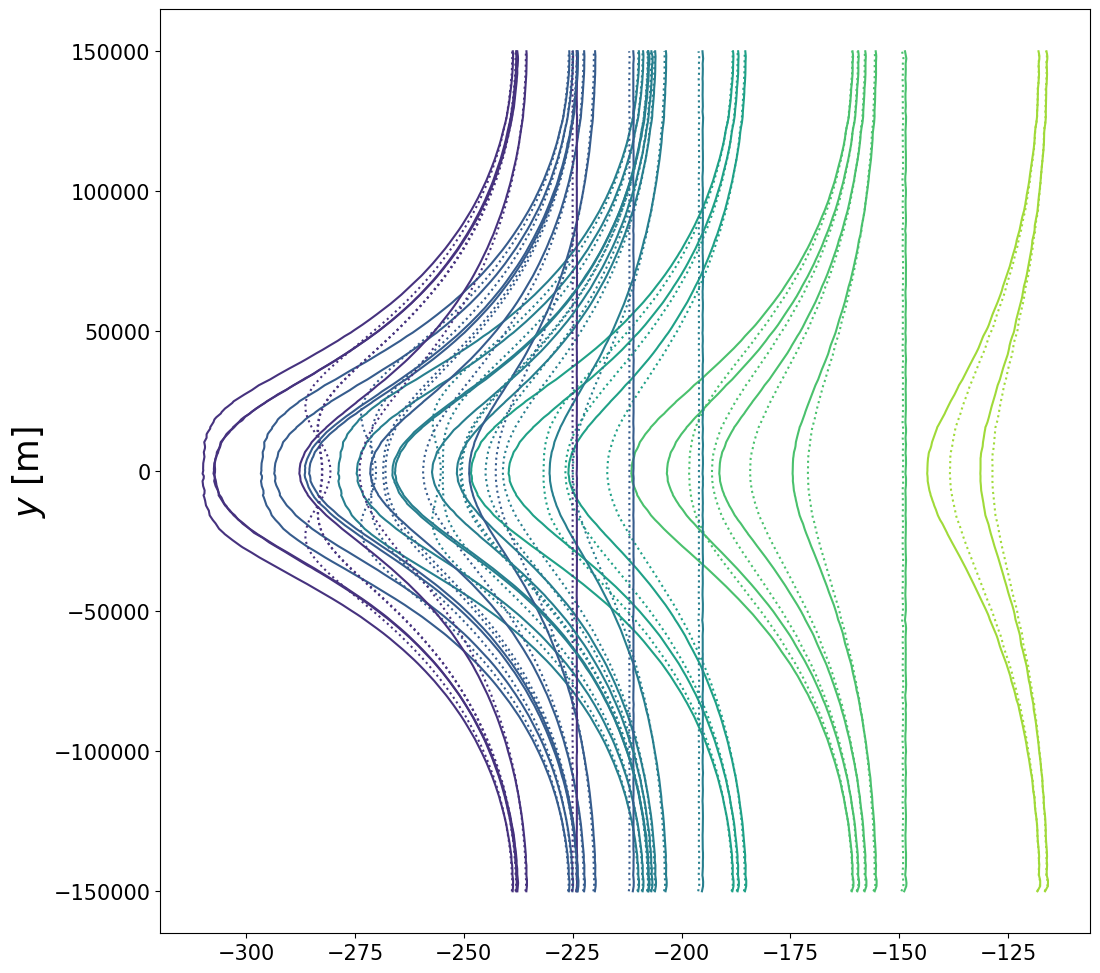

In [26]:
# Plot the stress in the x-direction

fig, ax = plt.subplots(1, 1, figsize=(12, 12))

for sim in sims:
    if sim[4:6] == '50':
        ax.plot(list(stress1[sim].values()), list(stress1[sim].keys()), label=sim, color=colors[0])
        ax.plot(list(hydp[sim].values()), list(hydp[sim].keys()), label=sim, linestyle='dotted', color=colors[0])
    else:
        ax.plot(list(stress1[sim].values()), list(stress1[sim].keys()), label=sim, color=colors[int(int(sim[4:6])/5)-1])
        ax.plot(list(hydp[sim].values()), list(hydp[sim].keys()), label=sim, linestyle='dotted', color=colors[int(int(sim[4:6])/5)-1])
ax.set_ylabel(r'$y$ [m]', size=25)
ax.tick_params(axis='both', which='major', labelsize=15)
#ax.legend(fontsize='12')
#ax.title.set_text(r'$v_{x,0} = $' + str(fluxes[i]) + ' [m a$^{-1}$]')
#ax.set_xlabel(r'$\tau_{xx}$ [MPa]', size=25)
#fig.savefig('../Figures/stress1_sigma.jpg', format='jpg', dpi=500, bbox_inches = "tight")

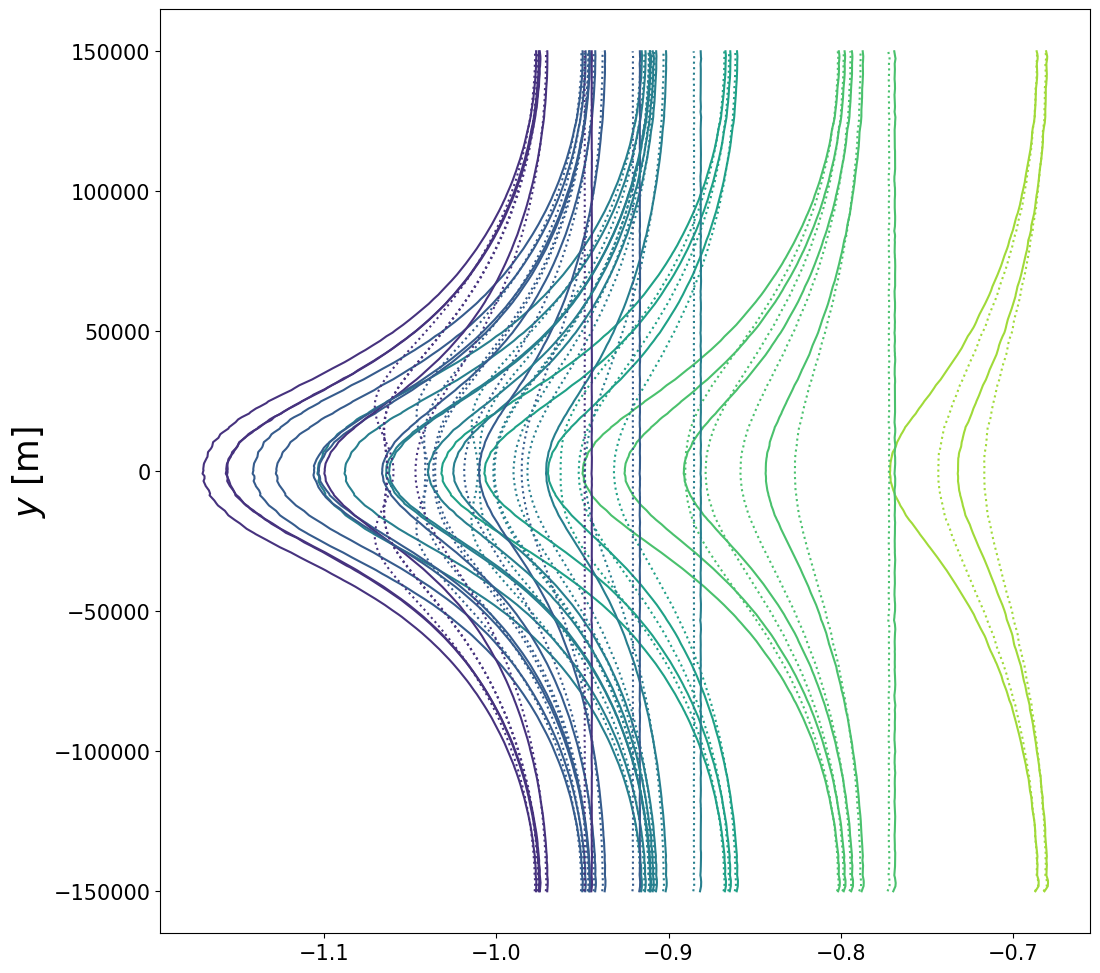

In [27]:
# Plot the 

fig, ax = plt.subplots(1, 1, figsize=(12, 12))

for sim in sims:
    if sim[4:6] == '50':
        ax.plot(list(stress1_div_thickness[sim].values()), list(stress1[sim].keys()), label=sim, color=colors[0])
        ax.plot(list(hydp_div_thickness[sim].values()), list(hydp[sim].keys()), label=sim, linestyle='dotted', color=colors[0])
    else:
        ax.plot(list(stress1_div_thickness[sim].values()), list(stress1[sim].keys()), label=sim, color=colors[int(int(sim[4:6])/5)-1])
        ax.plot(list(hydp_div_thickness[sim].values()), list(hydp[sim].keys()), label=sim, linestyle='dotted', color=colors[int(int(sim[4:6])/5)-1]) 
ax.set_ylabel(r'$y$ [m]', size=25)
ax.tick_params(axis='both', which='major', labelsize=15)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


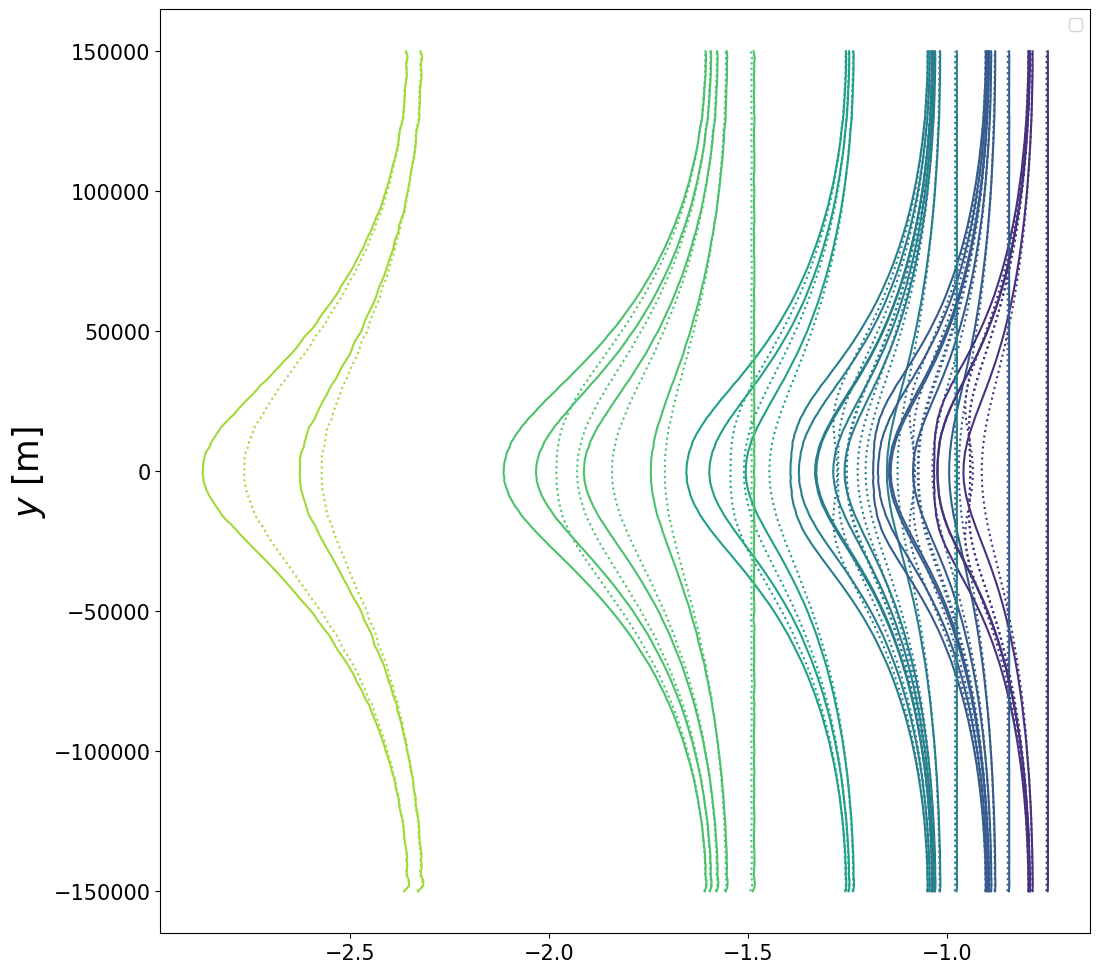

In [28]:
# Plot the stress in the x-direction

fig, ax = plt.subplots(1, 1, figsize=(12, 12))

for sim in sims:
    if sim[4:6] == '50':
        lst1 = list(stress1[sim].values())
        lst1 = [x / int(sim[4:6]) for x in lst1]
        lst2 = list(hydp[sim].values())
        lst2 = [x / int(sim[4:6]) for x in lst2]
        ax.plot(lst1, list(stress1[sim].keys()), color=colors[0])
        ax.plot(lst2, list(hydp[sim].keys()), linestyle='dotted', color=colors[0])
    else:
        lst1 = list(stress1[sim].values())
        lst1 = [x / int(sim[4:7]) for x in lst1]
        lst2 = list(hydp[sim].values())
        lst2 = [x / int(sim[4:7]) for x in lst2]
        ax.plot(lst1, list(stress1[sim].keys()), color=colors[int(int(sim[4:6])/5)-1])
        ax.plot(lst2, list(hydp[sim].keys()), linestyle='dotted', color=colors[int(int(sim[4:6])/5)-1])   
ax.legend(fontsize='12')
ax.set_ylabel(r'$y$ [m]', size=25)
ax.tick_params(axis='both', which='major', labelsize=15)


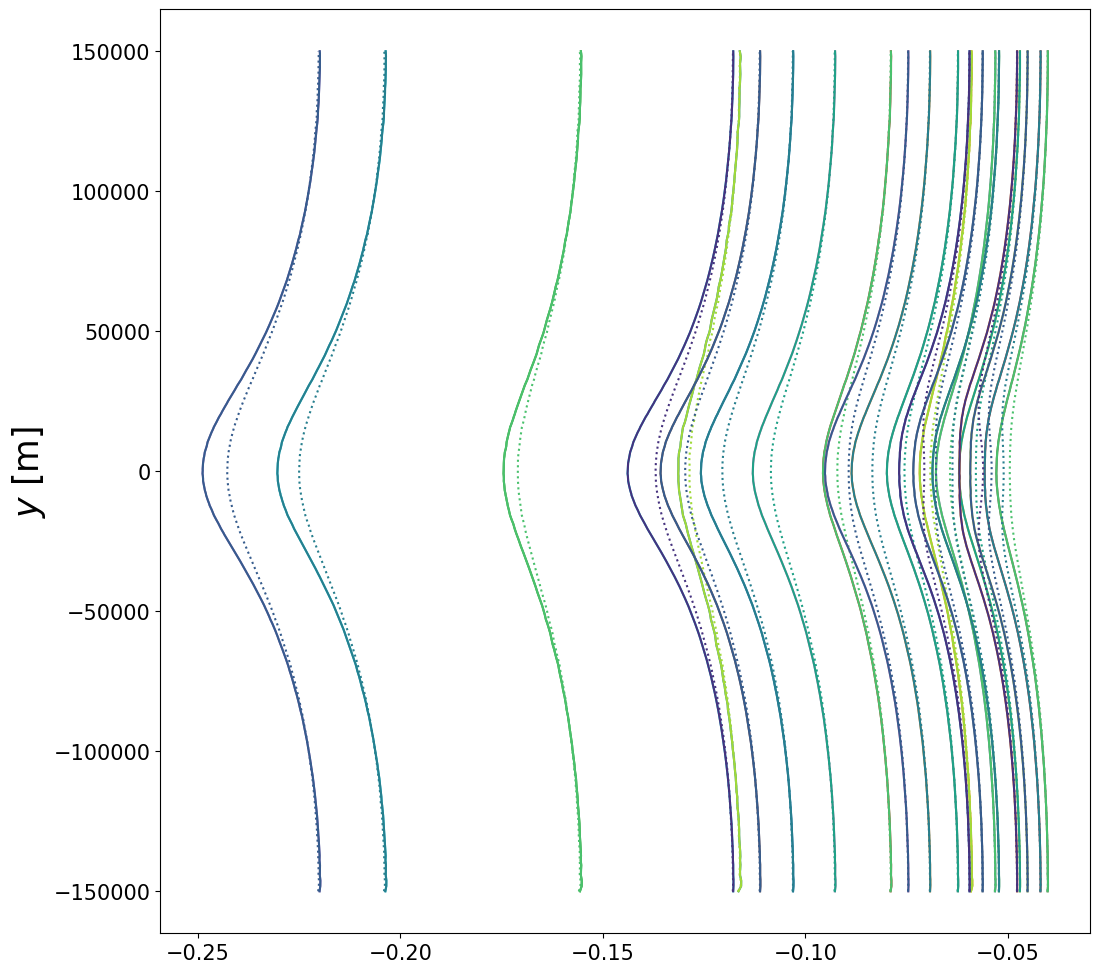

In [29]:
# Plot the stress in the x-direction 
#colors = sns.color_palette('tab10', n_colors=8).as_hex()
fig, ax = plt.subplots(1, 1, figsize=(12, 12))

for sim in sims:
    if sim[-3:] == 'int':
        pass
    elif sim[-3:] == 'cyl':
        pass
    elif sim[4:6] == '50':
        lst1 = list(stress1[sim].values())
        lst1 = [x / int(sim[-4:]) for x in lst1]
        lst2 = list(hydp[sim].values())
        lst2 = [x / int(sim[-4:]) for x in lst2]
        ax.plot(lst1, list(stress1[sim].keys()), label=sim)
        ax.plot(lst1, list(stress1[sim].keys()), label=sim, color=colors[0])
        ax.plot(lst2, list(hydp[sim].keys()), label=sim, linestyle='dotted', color=colors[0])
    else:
        lst1 = list(stress1[sim].values())
        lst1 = [x / int(sim[-4:]) for x in lst1]
        lst2 = list(hydp[sim].values())
        lst2 = [x / int(sim[-4:]) for x in lst2]
        ax.plot(lst1, list(stress1[sim].keys()), label=sim)
        ax.plot(lst1, list(stress1[sim].keys()), label=sim, color=colors[int(int(sim[4:6])/5)-1])
        ax.plot(lst2, list(hydp[sim].keys()), label=sim, linestyle='dotted', color=colors[int(int(sim[4:6])/5)-1])
ax.set_ylabel(r'$y$ [m]', size=25)
ax.tick_params(axis='both', which='major', labelsize=15)


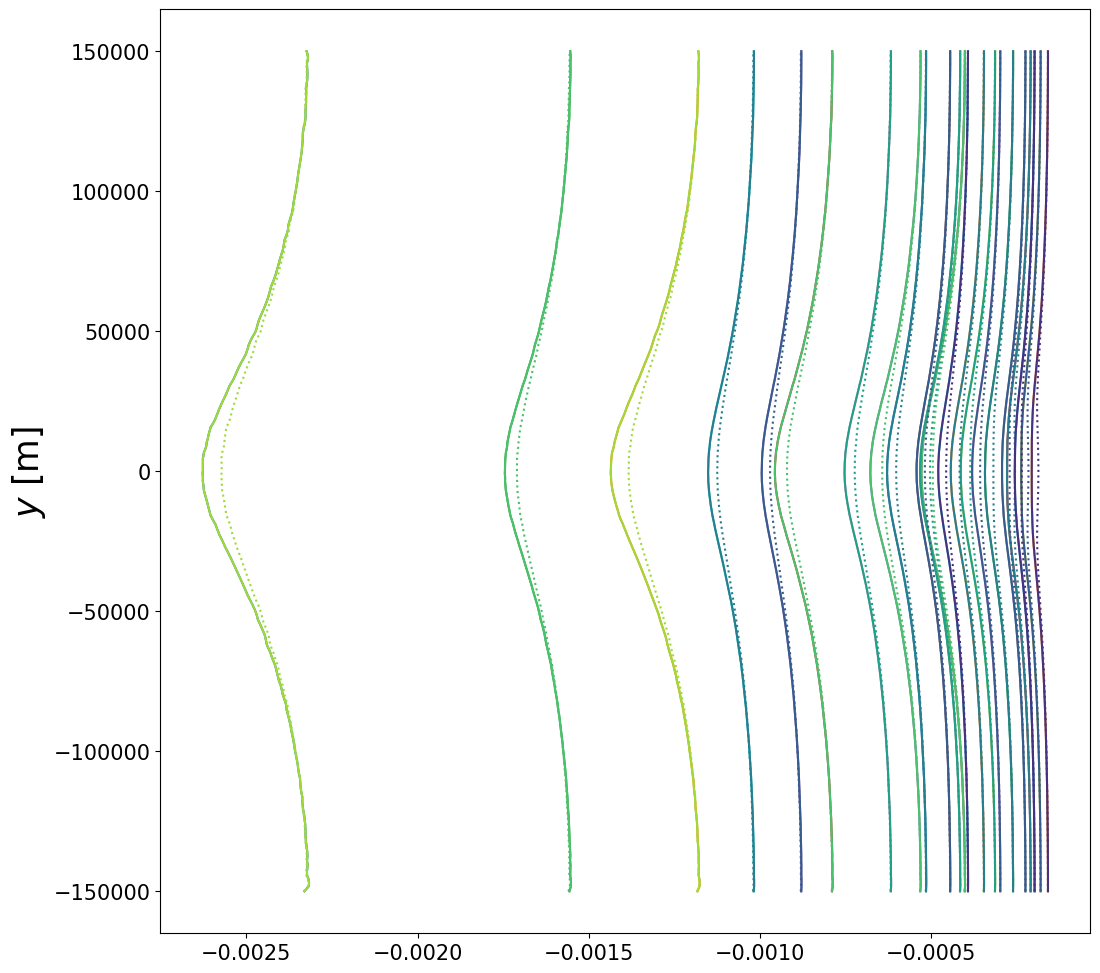

In [30]:
# Plot the stress in the x-direction 

fig, ax = plt.subplots(1, 1, figsize=(12, 12))

for sim in sims:
    if sim[-3:] == 'int':
        pass
    elif sim[-3:] == 'cyl':
        pass
    elif sim[4:6] == '50':
        lst1 = list(stress1[sim].values())
        lst1 = [x / (int(sim[-4:]) * int(sim[4:6])) for x in lst1]
        lst2 = list(hydp[sim].values())
        lst2 = [x / (int(sim[-4:]) * int(sim[4:6])) for x in lst2]
        ax.plot(lst1, list(stress1[sim].keys()), label=sim)
        ax.plot(lst1, list(stress1[sim].keys()), label=sim, color=colors[0])
        ax.plot(lst2, list(hydp[sim].keys()), label=sim, linestyle='dotted', color=colors[0])
    else:
        lst1 = list(stress1[sim].values())
        lst1 = [x / (int(sim[-4:]) * int(sim[4:7])) for x in lst1]
        lst2 = list(hydp[sim].values())
        lst2 = [x / (int(sim[-4:]) * int(sim[4:7])) for x in lst2]
        ax.plot(lst1, list(stress1[sim].keys()), label=sim)
        ax.plot(lst1, list(stress1[sim].keys()), label=sim, color=colors[int(int(sim[4:6])/5)-1])
        ax.plot(lst2, list(hydp[sim].keys()), label=sim, linestyle='dotted', color=colors[int(int(sim[4:6])/5)-1])
ax.set_ylabel(r'$y$ [m]', size=25)
ax.tick_params(axis='both', which='major', labelsize=15)